## Data Loading and Initial Setup

Here we import all necessary libraries and set up our development environment:
- Data manipulation: pandas, numpy
- Visualization: matplotlib, seaborn
- Machine learning: scikit-learn, XGBoost
- Model tracking: MLflow

We'll use these libraries throughout the notebook for data processing, model training, and evaluation.

In [84]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MLflow
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
import inspect

# Scikit-learn preprocessing and pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, auc,
    precision_score, recall_score, f1_score
)

# Logging configuration
import logging
logging.getLogger("mlflow.models.model").setLevel(logging.ERROR)

# Warnings management
import warnings

In [10]:
mlflow.set_tracking_uri("file:///C:/Users/Galyna/mlruns")
print(mlflow.get_tracking_uri())

file:///C:/Users/Galyna/mlruns


In [11]:
mlflow.set_experiment("Social Media Project Logistic Regression")
mlflow.set_experiment_tag("scikit-learn", "lr")

In [12]:
mlflow.set_tag("dataset", "social_sphere_v1")  

In [85]:
def log_model_run(
    model,                       # fitted estimator or pipeline
    params: dict,                # dict of hyper-parameters
    train_X, train_y,            # training data
    val_X,   val_y,              # validation data
    model_name: str = "Model",   # readable name for the run
    pos_label: int = 1,          # positive class
    experiment_name: str | None = None,   # optional: switch experiment
):
    """
    Generic MLflow run logger for binary-classification estimators that expose
    predict() and *optionally* predict_proba() / decision_function().
    """
    warnings.filterwarnings("ignore", message=".*Inferred schema contains integer column.*")

    # ------------------------------------------------------------------ #
    # 0) MLflow bookkeeping                                              #
    # ------------------------------------------------------------------ #
    if experiment_name:
        mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name=model_name):
        # ----------------------- Hyper-parameters ---------------------- #
        mlflow.log_params(params)

        # ----------------------- Dataset lineage ---------------------- #
        mlflow.log_input(
            mlflow.data.from_pandas(train_X, name="train_v1"), context="training"
        )
        mlflow.log_input(
            mlflow.data.from_pandas(val_X,   name="val_v1"),   context="validation"
        )

        # ----------------------- Predictions -------------------------- #
        train_preds = model.predict(train_X)
        val_preds   = model.predict(val_X)

        # --- Probabilities or decision scores (needed for ROC/AUC) ---- #
        if hasattr(model, "predict_proba"):
            train_scores = model.predict_proba(train_X)[:, 1]   # pos class prob
            val_scores   = model.predict_proba(val_X)[:, 1]
        elif hasattr(model, "decision_function"):
            train_scores = model.decision_function(train_X)
            val_scores   = model.decision_function(val_X)
        else:   # fall-back: cannot compute ROC/AUC
            train_scores = val_scores = None

        # ----------------------- Metrics ------------------------------ #
        metrics = {
            "accuracy_train":  accuracy_score(train_y, train_preds),
            "precision_train": precision_score(train_y, train_preds, pos_label=pos_label),
            "recall_train":    recall_score(train_y, train_preds,   pos_label=pos_label),
            "f1_train":        f1_score(train_y, train_preds,       pos_label=pos_label),
            "accuracy_val":    accuracy_score(val_y, val_preds),
            "precision_val":   precision_score(val_y, val_preds,   pos_label=pos_label),
            "recall_val":      recall_score(val_y, val_preds,       pos_label=pos_label),
            "f1_val":          f1_score(val_y, val_preds,           pos_label=pos_label),
        }

        if train_scores is not None:
            metrics["roc_auc_train"] = roc_auc_score(train_y, train_scores)
            metrics["roc_auc_val"]   = roc_auc_score(val_y,   val_scores)

        mlflow.log_metrics(metrics)

        # -------------------- Confusion matrices ---------------------- #
        for split, y_true, y_pred in [
            ("train", train_y, train_preds),
            ("val",   val_y,   val_preds)
        ]:
            cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

            fig, ax = plt.subplots()
            ConfusionMatrixDisplay(cm,
                                   display_labels=["Low (0)", "High (1)"]
                                  ).plot(ax=ax, cmap="Purples")
            ax.set_title(f"Confusion Matrix – {split.capitalize()}")

            mlflow.log_figure(fig, f"plots/conf_matrix_{split}.png")
            plt.close(fig)

        # -------------------- ROC curves (if available) --------------- #
        if train_scores is not None:
            for split, y_true, y_score, auc in [
                ("train", train_y, train_scores, metrics["roc_auc_train"]),
                ("val",   val_y,   val_scores,   metrics["roc_auc_val"])
            ]:
                fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=pos_label)

                fig, ax = plt.subplots()
                ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
                ax.plot([0, 1], [0, 1], "k--")
                ax.set_xlabel("False Positive Rate")
                ax.set_ylabel("True Positive Rate")
                ax.set_title(f"ROC Curve – {split.capitalize()}")
                ax.legend()

                mlflow.log_figure(fig, f"plots/roc_curve_{split}.png")
                plt.close(fig)

        # -------------------- Model itself ---------------------------- #
        # Detect the correct MLflow flavour (simple heuristic)
        if "sklearn" in inspect.getmodule(model).__name__:
            mlflow.sklearn.log_model(
                model,
                name=f"{model_name.lower().replace(' ', '_')}_pipeline",
                input_example=val_X.iloc[:1].copy(),
                signature=infer_signature(train_X, train_preds),
                registered_model_name=model_name
            )
        else:
            # fall-back = log as generic pyfunc
            mlflow.pyfunc.log_model(
                name=f"{model_name.lower().replace(' ', '_')}_model",
                python_model=model,
                registered_model_name=model_name
            )

        # --------------- return metrics for convenience --------------- #
        return metrics

In [3]:
df = pd.read_csv('data.csv') 

## Feature Engineering and Preprocessing

In this section, we:
1. Create a binary target variable for conflicts over social media (High/Low)
2. Handle country information by grouping less frequent countries
3. Separate features into numeric and categorical columns
4. Set up preprocessing pipelines for both types of features:
   - Numeric features: StandardScaler
   - Categorical features: OneHotEncoder

We'll exclude certain columns that shouldn't be used as features (e.g., IDs and target-related columns).

In [59]:
df["Conflicts_Over_Social_Media_Binary"] = df["Conflicts_Over_Social_Media"].apply(lambda x: 0 if x <= 2 else 1).astype(int)


Text(0, 0.5, 'Count')

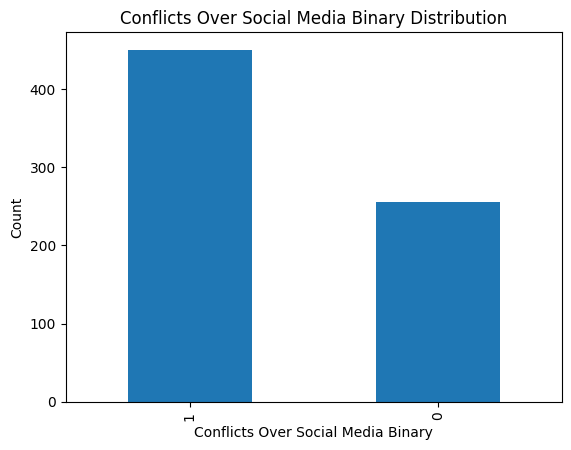

In [60]:
df["Conflicts_Over_Social_Media_Binary"].value_counts().plot(kind='bar', title='Conflicts Over Social Media Binary Distribution')
plt.xlabel('Conflicts Over Social Media Binary')
plt.ylabel('Count')

In [61]:
country_counts = df['Country'].value_counts()
df['country_grouped'] = df['Country'].apply(lambda x: x if country_counts[x] > 1 else 'Other')

In [62]:
df.head()

,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score,Conflicts_Over_Social_Media_Binary,country_grouped
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8,1,Bangladesh
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3,0,India
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9,1,USA
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4,0,UK
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7,0,Canada


In [63]:
exclude_cols = ['Student_ID', 'Conflicts_Over_Social_Media', 'Country', 'Conflicts_Over_Social_Media_Binary', 'Addicted_Score'] 
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
print(numeric_cols)

['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score']


In [64]:
categoric_cols = df.select_dtypes(include='object').columns
categoric_cols = [col for col in categoric_cols if col not in exclude_cols]
print(categoric_cols)

['Gender', 'Academic_Level', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status', 'country_grouped']


In [65]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Conflicts_Over_Social_Media_Binary'])

## Model Development

### Data Split and Pipeline Setup
We split our data into training and validation sets with a 80-20 split ratio. For the models, we:
1. Create preprocessing pipelines that combine numeric and categorical transformers
2. Set up model hyperparameters
3. Create full pipelines that combine preprocessing and model training
4. Train the models and make predictions

We'll implement two models:
1. Logistic Regression - as a baseline model
2. XGBoost - as our main model

In [68]:
input_cols = numeric_cols + categoric_cols
target_col = 'Conflicts_Over_Social_Media_Binary'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

In [69]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [67]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [15]:
lr_params = {
    "solver": "liblinear",
    "class_weight":'balanced',
    "C": 0.1, 
    "max_iter": 1000,
    "random_state": 42,
}

In [17]:
# Define preprocessing and pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categoric_cols)]
)

# Create a more robust model with adjusted hyperparameters
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(**lr_params)) 
])

# Fit the model and get predictions to check class balance
lr_pipeline.fit(train_inputs, train_targets)
train_preds = lr_pipeline.predict(train_inputs)
val_preds = lr_pipeline.predict(val_inputs)

## 4. Model Evaluation and MLflow Tracking

For each model, we evaluate and track:
1. Classification Metrics:
   - Accuracy
   - Precision
   - Recall
   - F1 Score
   - ROC AUC Score

2. Visualizations:
   - Confusion Matrices
   - ROC Curves

All results are logged to MLflow for experiment tracking and model comparison. We store:
- Model parameters
- Evaluation metrics
- Model artifacts (plots and data)
- Model signatures for deployment

#### Logistic Regression

In [82]:
log_model_run(
    model=lr_pipeline,
    params=lr_params,
    train_X=train_inputs, train_y=train_targets,
    val_X=val_inputs,     val_y=val_targets,
    model_name="Logistic Regression"
)


Registered model 'Logistic Regression' already exists. Creating a new version of this model...
Created version '23' of model 'Logistic Regression'.
Registered model 'Logistic Regression' already exists. Creating a new version of this model...
Created version '23' of model 'Logistic Regression'.


{'accuracy_train': 0.9929078014184397,
 'precision_train': 0.9917127071823204,
 'recall_train': 0.9972222222222222,
 'f1_train': 0.9944598337950139,
 'accuracy_val': 1.0,
 'precision_val': 1.0,
 'recall_val': 1.0,
 'f1_val': 1.0,
 'roc_auc_train': np.float64(0.9973175381263616),
 'roc_auc_val': np.float64(1.0)}

#### XGBoost

In [86]:
cat_features = train_inputs.select_dtypes(include='object').columns
train_inputs[cat_features] = train_inputs[cat_features].astype('category')
val_inputs[cat_features] = val_inputs[cat_features].astype('category')

In [87]:
xgb_params = {
    "max_depth": 3,
    "n_estimators": 10,
    "enable_categorical": True,
    "random_state": 42
}


xgb = XGBClassifier(
        ** xgb_params,
     ).fit(train_inputs, train_targets)



log_model_run(
    model=xgb,
    params=xgb_params,
    train_X=train_inputs, train_y=train_targets,
    val_X=val_inputs,     val_y=val_targets,
    model_name="XGBoost"
)

Registered model 'XGBoost' already exists. Creating a new version of this model...

Registered model 'XGBoost' already exists. Creating a new version of this model...
Created version '6' of model 'XGBoost'.
Created version '6' of model 'XGBoost'.


{'accuracy_train': 0.9946808510638298,
 'precision_train': 0.9917355371900827,
 'recall_train': 1.0,
 'f1_train': 0.995850622406639,
 'accuracy_val': 1.0,
 'precision_val': 1.0,
 'recall_val': 1.0,
 'f1_val': 1.0,
 'roc_auc_train': np.float64(0.9978145424836602),
 'roc_auc_val': np.float64(1.0)}